## Import of Libraries

In [1]:
import json

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from yellowbrick.classifier.rocauc import roc_auc

!pip install scikit_optimize # Needed to work with skopt
from skopt import BayesSearchCV

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.1 MB/s eta 0:00:00


## Preprocessing
In this particular case the usual process follows the following steps:
1. Tokenization: Split the text into words (using whitespace or regular expressions)
2. Normalization: Transform the tokens to a unique format so that the same word (lower case, removal of accents, non-ASCII characters...)
3. Elimination of stop words: Remove words that have no meaning by themselves (prepositions, adverbs, articles). It clearly depends on the language.
4. Lemmatization: Transformation of words to their root. This also depends on the language
5. Reduction of vocabulary to a range of frequencies (neither the most frequent nor the very infrequent)
6. Transformation of each text to a feature vector:
    - Binary (the word is there or not)
    - Count (How many times the word appears)
    - Importance of the word with respect to the set of documents, for example TFIDF
         
         TF = term frequency, how many times the word appears in the document
         IDF = inverse document frequency, in how many documents the word appears

This representation of the text is known as **Bag of words**, it represents each document by a list of words belonging to a vocabulary and an attribute calculated for each of them.

Once we have the data as a matrix we can apply any model.

In [3]:
# Needed to Read Files
import json
with open("text", "r") as fp:
  text = json.load(fp)

import json
with open("labels", "r") as fp:
  labels = json.load(fp)

We have 4000 examples in total

In [4]:
len(text), len(labels)

(4000, 4000)

This is the first example

In [5]:
text[0], labels[0]

("b'There is now ample evidence that dust is already present in abundance at high z. However, given the faintness of distant galaxies in the optical and the NIR, datasets are still limited and how the dust affects the emerging radiation of galaxies at very high redshift is not yet fully understood. Using the ALPINE survey, our objective is to quantify the dust attenuation properties in galaxies at z=4.4-5.5, and in particular the shape of their attenuation curve. Using the CIGALE code, we model the stellar populations and their interaction with the dust in order to measure some of the physical properties of a subsample of 23 main-sequence ALPINE galaxies. We find that the attenuation curves span a broad range of properties, from curves that are much steeper than the SMC extinction curve, to shallower than the starburst attenuation curve. The shape of the attenuation curves strongly depends on the V-band attenuation. Galaxies with the lowest attenuation also present the steepest curves.

Before processing the text we will divide it into a training and test set, we will also transform the textual labels to numbers

In [7]:
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.3, random_state=42, stratify=labels)

In [8]:
lenc = LabelEncoder()
y_train_l = lenc.fit_transform(y_train)
y_test_l = lenc.transform(y_test)
cls = lenc.inverse_transform(np.unique(y_train_l))

In [9]:
X_train[0]

"b'The Gauss-Bonnet curvature invariant has attracted the attention of physicists and mathematicians over the years. In particular, it has recently been proved that black holes can support external matter configurations that are non-minimally coupled to the Gauss-Bonnet invariant of the curved spacetime. Motivated by this physically interesting behavior of black holes in Einstein-Gauss-Bonnet theories, we present a detailed {\\\\it analytical} study of the physical and mathematical properties of the Gauss-Bonnet curvature invariant ${\\\\cal G}_{\\\\text{Kerr}}(r,\\\\cos\\\\theta;a/M)$ of spinning Kerr black holes in the spacetime region outside the horizon. Interestingly, we prove that, for all spinning Kerr spacetimes in the physically allowed regime $a/M\\\\in[0,1]$, the spin-dependent maximum curvature of the Gauss-Bonnet invariant is attained at the equator of the black-hole surface. Intriguingly, we reveal that the location of the global minimum of the Gauss-Bonnet invariant has 

### Transformation to data matrix

We will consider different ways to transform the text to a data matrix, for this purpose scikit-learn has two special functions for it:

-  `CountVectorizer` which allows to get the word count, but also the binary representation
-  `TfidfVectorizer` which calculates the TFIDF of the words


Empezaremos por el mas sencillo, una representación binaria.


We will modify the following attributes:

 - `max_features` the number of words in the vocabulary, by default the most frequent ones are chosen, which might not be the best option, you can control the range of frequencies that is chosen with other parameters, we will try several options
 - `stop_words` that we will put to `english`

The vectorizer returns a sparse matrix when it makes sense, this will reduce the memory cost, but not all models can work with this representation.

In [10]:
voc_size = 1000

cvec = CountVectorizer(stop_words='english', max_features=voc_size, binary=True)

X_train_v = cvec.fit_transform(X_train)
X_test_v = cvec.transform(X_test)
X_train_v.shape

(2800, 1000)

We can visualize the vocabulary we have

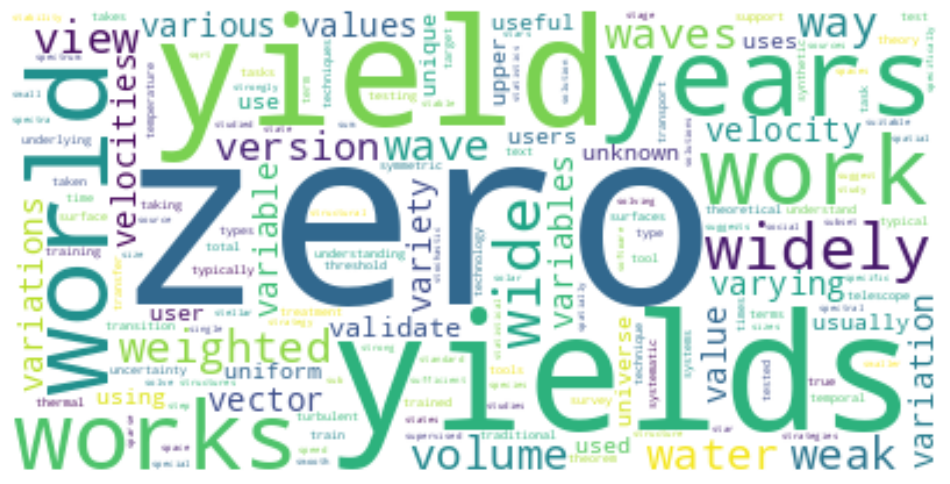

In [11]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white').generate_from_frequencies(cvec.vocabulary_)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear');
plt.axis('off');

### Dimensionality Reduction

Clearly we can't do exploratory analysis of variables or detailed visualization, so we'll use dimensionality reduction to look at the relationship between attributes and classes.
####Principal Component Analysis
We apply Principal Component Analysis (PCA)

<Axes: xlabel='0', ylabel='1'>

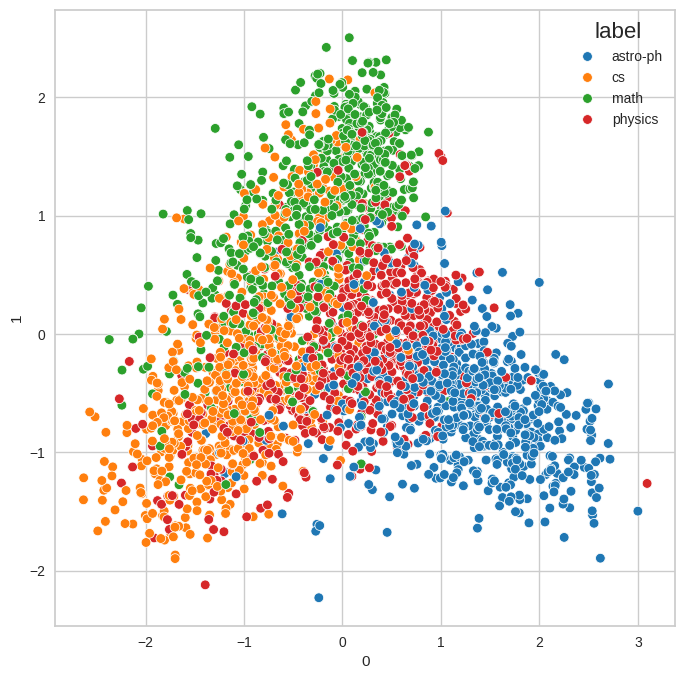

In [22]:
pca = PCA()
tdata = pca.fit_transform(np.asarray(X_train_v.todense())) # Convert to numpy array
dfdata = pd.concat([pd.DataFrame(tdata[:,:2]), pd.DataFrame({'label':y_train})], axis=1)
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=0, y=1, hue='label', data=dfdata, palette='tab10')

We can see that there is some separability between the classes, also the projection gives us an idea of the relationships between them.

## Support Vector Machines
The idea of a SVM is to find the optimal separator between the classes that will correspond to the hyperplane that maximizes the margin between them.

If the classes are not linearly separable (as probably happens in our case) we can put a limit on the error that the classifier makes to find the separator. We can also use different kernels that increase the dimensionality of the space to more easily get the separator.

In this practise we will work with the linear SVM, the SVM with polynomial kernel and the SVM with RBF kernel.

### Linear Kernel

We will start with the linear SVM.

Before using it, the usual thing is to normalize the data to use the SVM. In this case we don't need it since the data is binary, but it could help convergence in other cases.


The C argument tells the SVM optimization how much we want to avoid misclassifying each training example.

In [23]:
param = {'C':10**np.linspace(-3,3,101)}

lsvc = SVC(kernel='linear', max_iter=25000, random_state=0)
lsvc_search = BayesSearchCV(lsvc,param,n_iter=15, cv=5, n_jobs=-1, refit=True, random_state=0)
lsvc_search.fit(X_train_v, y_train_l);

In [24]:
show_html(pd.DataFrame(lsvc_search.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
11,{'C': 0.012022644346174132},0.782,1
3,{'C': 0.006918309709189363},0.781,2
4,{'C': 0.023988329190194897},0.776,3
8,{'C': 0.0034673685045253167},0.772,4
1,{'C': 0.03630780547701014},0.765,5


### Classification Report

In [25]:
print(classification_report(lsvc_search.predict(X_test_v), y_test_l,target_names=cls))

              precision    recall  f1-score   support

    astro-ph       0.86      0.91      0.88       286
          cs       0.72      0.75      0.74       289
        math       0.78      0.73      0.76       322
     physics       0.73      0.72      0.72       303

    accuracy                           0.77      1200
   macro avg       0.77      0.78      0.77      1200
weighted avg       0.77      0.77      0.77      1200



Astrophysics articles seem to be the ones that rank best.


### Confusion Matrix

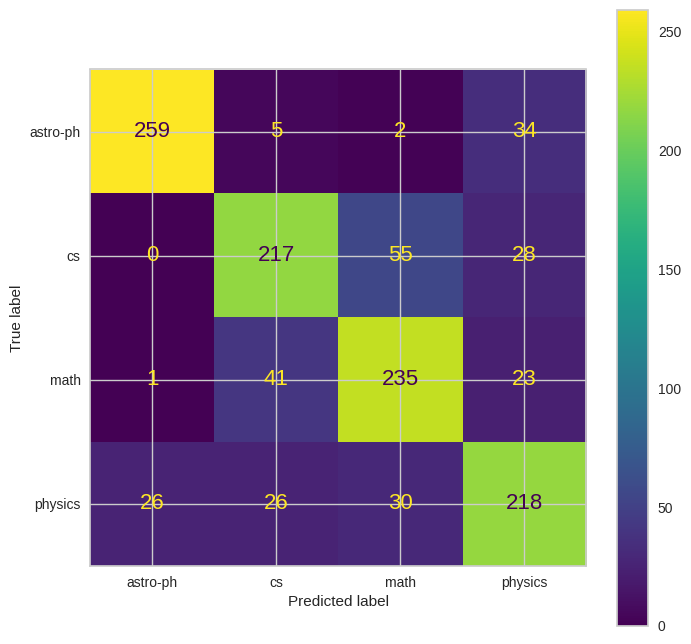

In [26]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(lsvc_search,X_test_v,y_test_l,display_labels=cls,ax=plt.subplot())

The physics documents are the ones that have the most confusion with the rest, those of astrophysics are not so similar to those of CS or mathematics and there is also some overlap between these two.

###Roc Curve
The Receiver Operating Characteristic (ROC) is a measure of a classifier’s predictive quality that compares and visualizes the tradeoff between the model’s sensitivity and specificity. When plotted, a ROC curve displays the true positive rate on the Y axis and the false positive rate on the X axis on both a global average and per-class basis. The ideal point is therefore the top-left corner of the plot: false positives are zero and true positives are one.

This leads to another metric, area under the curve (**AUC**), which is a computation of the relationship between false positives and true positives. The higher the AUC, the better the model generally is. We want AUC to be equal to 1.

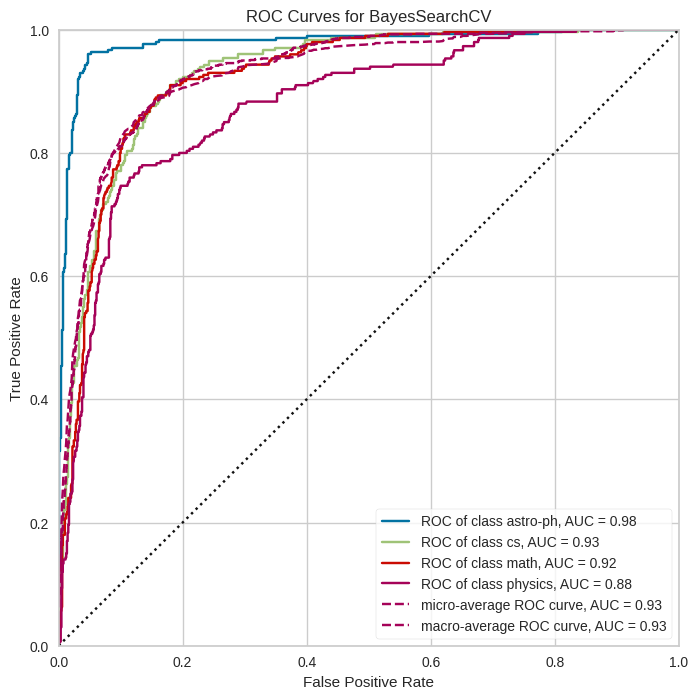

ROCAUC(ax=<Axes: title={'center': 'ROC Curves for BayesSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=array(['astro-ph', 'cs', 'math', 'physics'], dtype='<U8'),
       estimator=BayesSearchCV(cv=5,
                               estimator=SVC(kernel='linear', max_iter=25000,
                                             random_state=0),
                               n_iter=15, n_jobs=-1, random_state=0,
                               search_spaces={'C': array([1.00000000e-03, 1.14815...
       3.63078055e+01, 4.16869383e+01, 4.78630092e+01, 5.49540874e+01,
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03])}))

In [27]:
plt.figure(figsize=(8,8))

roc_auc(lsvc_search,X_train_v, y_train_l, X_test_v, y_test_l, classes = cls)

In the ROC curve we can also see that the astrophysics articles are the ones that are best distinguished.